In [114]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [115]:
path = "./IBD_data.csv"
df = pd.read_csv(path)
df = df.set_index('Unnamed: 0') # Prendre sample_name comme index
df = df.drop("sample_name",axis="columns") # L'enlever du df
df = df.dropna(axis=1,how='all') # Drop les colonnes ou on a que des NA values 
df = df.dropna(axis=0,how='any') # Drop les lignes ou on a au moins une NA value

# Suppression des colonnes avec une seule valeur unique
for column in df.columns : 
   if len(df[column].value_counts()) == 1 : 
      df.pop(column)
      
# Suppression des colonnes non pertinentes
df.pop("age_category") 
df.pop("run_name")
df.pop("second_sample_name")

Unnamed: 0
SAMEA1963786    ERS199311
SAMEA1964348    ERS199223
SAMEA1964895    ERS199262
SAMEA1964914    ERS199243
SAMEA1965033    ERS199027
                  ...    
SAMEA2043048    ERS199238
SAMEA2043049    ERS199239
SAMEA2043050    ERS199240
SAMEA2043051    ERS199242
SAMEA2043052    ERS199244
Name: second_sample_name, Length: 393, dtype: object

In [116]:
# path_2 = "./IBD_data/IBD_data/rawData/1939_20180418-110402.txt"
# df_2 = pd.read_csv(path_2,sep="\t")

In [117]:
# print(df.isna().sum())         # nombre de NaN par colonne
# print(len(df) - df.isna().sum())  # nombre de non-NaN par colonne

In [118]:
df.columns
# df["age"].plot.hist()
# plt.xlabel("Age")
# plt.ylabel("Fréquence")
# plt.title("Histogramme de l'age dans le dataset")
# plt.show()

Index(['number_bases', 'disease', 'phenotype', 'country', 'sex', 'age', 'BMI'], dtype='object')

In [119]:
# Encodage des variables catégorielles
df['disease'] = df["disease"].apply(lambda x : 0 if x.lower() == "health" else 1) # 0 = healthy, 1 = IBD
df['sex'] = df["sex"].apply(lambda x : 0 if x.lower() == "male" else 1)    # 0 = male, 1 = female
df['country'] = df["country"].apply(lambda x : 0 if x.lower() == "esp" else 1) # 0 = esp, 1 = dnk
df["phenotype"] = df["phenotype"].apply(lambda x : 0 if x == "" else (1 if x.lower() == "cd" else 2)) # 0 = control, 1 = cd, 2 = uc

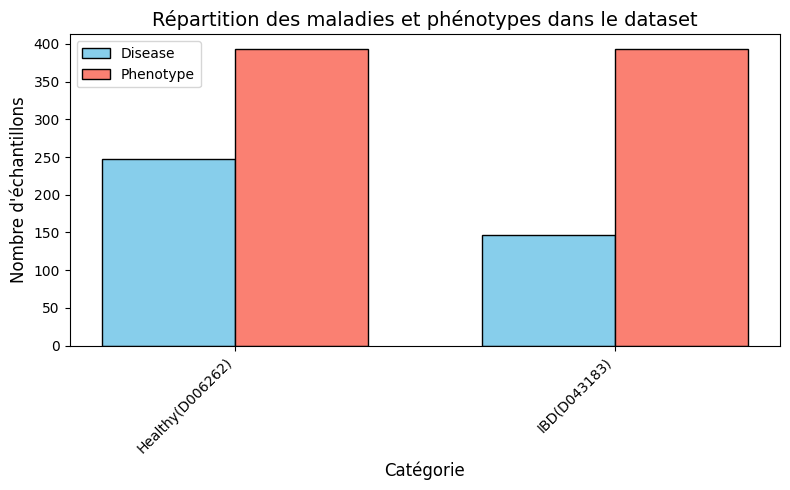

In [120]:
# Compter les occurrences de chaque maladie
counts_disease = df["disease"].value_counts()
counts_phenotype = df["phenotype"].value_counts()

# Tracer l'histogramme pour montrer que phénotype et génotype sont très corrélés
plt.figure(figsize=(8, 5))
width = 0.35  # largeur des barres
x = np.arange(len(counts_disease.index))  # la position des barres
plt.bar(x - width/2, counts_disease.values, width, label='Disease', color='skyblue', edgecolor='black')
plt.bar(x + width/2, counts_phenotype.values, width, label='Phenotype', color='salmon', edgecolor='black')
plt.xlabel('Catégorie', fontsize=12)
plt.ylabel('Nombre d\'échantillons', fontsize=12)
plt.title('Répartition des maladies et phénotypes dans le dataset', fontsize=14)
plt.xticks(x, ['Healthy(D006262)', 'IBD(D043183)'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
pd.crosstab(df["disease"],df["phenotype"]) # Très corrélés
# On peut donc se débarrasser de "phenotype"

phenotype,2
disease,
0,247
1,146


In [122]:
df.pop("phenotype")

Unnamed: 0
SAMEA1963786    2
SAMEA1964348    2
SAMEA1964895    2
SAMEA1964914    2
SAMEA1965033    2
               ..
SAMEA2043048    2
SAMEA2043049    2
SAMEA2043050    2
SAMEA2043051    2
SAMEA2043052    2
Name: phenotype, Length: 393, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV
scaler = StandardScaler()
X = df.drop("disease",axis="columns") # Toutes les colonnes sauf disease
y = df["disease"] # Seulement la colonne disease
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=df["disease"]) # stratify pour garder la même proportion de chaque classe dans train et test
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.fit_transform(X_test)


In [ ]:
# On va tester avec un random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


rf = RandomForestClassifier(random_state=42,class_weight='balanced')

# scoring = {'F1' : 'f1','ROC_AUC' : 'roc_auc'}
params_grid = {
    'max_depth' : np.arange(1,40,10) , 
    'n_estimators' : np.arange(1,200,50), 
    'min_samples_split' : [2,5,10], 
    'min_samples_leaf' : [1,2,4], 
    'bootstrap' : [True,False]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params_grid,
                           cv=cv,scoring='f1_macro',
                           n_jobs=-1,
                           verbose=1,
                           return_train_score=True)

grid_search.fit(X_train_stand,y_train)

# Prepare results summary
print("Meilleures paramètres :",grid_search.best_params_)




Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Meilleures paramètres : {'bootstrap': False, 'max_depth': np.int64(11), 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': np.int64(101)}


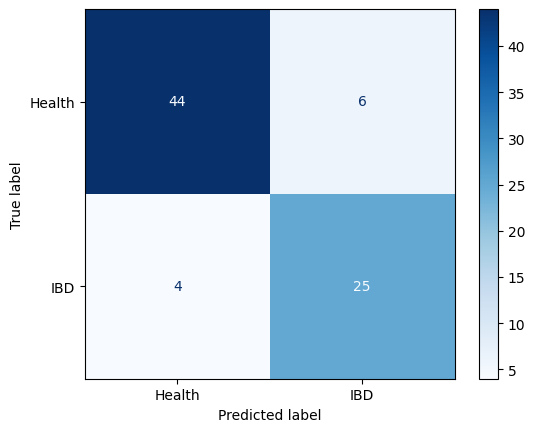

              precision    recall  f1-score   support

      Health       0.92      0.88      0.90        50
         IBD       0.81      0.86      0.83        29

    accuracy                           0.87        79
   macro avg       0.86      0.87      0.87        79
weighted avg       0.88      0.87      0.87        79



In [ ]:
y_pred = grid_search.predict(X_test_stand)
y_proba = grid_search.predict_proba(X_test_stand)[:,1]

# Matrice de confusion
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=["Health","IBD"])
cm_display.plot(cmap='Blues',values_format='d')
plt.show()
print(classification_report(y_test,y_pred,target_names=["Health","IBD"]))

In [ ]:
# # Pour transformer la colonne age_category en variable de type numérique
# for index,row in df.iterrows() :
#     if "young adult" in row["age_category"] : 
#         df["age_category_new"] = 1
#     elif "middle-aged" in row["age_category"] : 
#         df["age_category_new"] = 2
#     else :
#         df["age_category_new"] = 3

# Avec labelencoder de sklearn
# le = LabelEncoder()
# df["age_category"] = le.fit_transform(df["age_category"])

In [26]:
df.head()

,project_name,bioproject,is_available,run_name,second_sample_name,number_bases,instrument_model,disease,phenotype,country,sex,age,age_category,BMI
Unnamed: 0,,,,,,,,,,,,,,
SAMEA1963786,ERP002061,PRJEB1220,YES,ERR210598; ERR210597; ERR209746; ERR209745,ERS199311,5774389982,IlluminaHiSeq,Irritable Bowel Syndrome,D043183,ESP,Female,36.0,1,19.8
SAMEA1964348,ERP002061,PRJEB1220,YES,ERR210457; ERR209605,ERS199223,3485248875,IlluminaHiSeq,Irritable Bowel Syndrome,D043183,ESP,Female,39.0,1,30.3
SAMEA1964895,ERP002061,PRJEB1220,YES,ERR210516; ERR209664,ERS199262,4322932710,IlluminaHiSeq,Health,D006262,ESP,Male,29.0,3,26.2
SAMEA1964914,ERP002061,PRJEB1220,YES,ERR210486; ERR210485; ERR210484; ERR209633; ER...,ERS199243,3369149157,IlluminaHiSeq,Irritable Bowel Syndrome,D043183,ESP,Female,29.0,3,21.5
SAMEA1965033,ERP002061,PRJEB1220,YES,ERR209977; ERR209976; ERR209125; ERR209124,ERS199027,3618371490,IlluminaHiSeq,Health,D006262,DNK,Female,44.0,1,22.7
